In [ ]:
%%HTML
<!-- Make fonts readable at 1024x768 -->
<style>
.rendered_html { font-size:1.0em; }
</style>

In [1]:
import numpy as np
import scipy.signal
%matplotlib notebook
import matplotlib.pylab as plt
from matplotlib import animation, patches
from IPython.display import display, Audio, HTML
import soundfile as sf
from style import *

### Bibliografía

1. Weifeng Liu, José Príncipe, Simon Haykin, "Kernel adaptive filtering", Wiley

***
# Filtros adaptivos no-lineales 
***
- Los filtros lineales son sencillos (baja capacidad)
- Hasta ahora hemos asumido que la salida y la entrada se relacionan linealmente
$$
y_n = \langle \textbf{w}, \textbf{u}_n \rangle = \textbf{w}^T \textbf{u}_n = \sum_{k=0}^L w_{k} u_{nk}
$$
- Si esto no se cumple el desempeño del filtro sería subóptimo

<IPython.core.display.Javascript object>


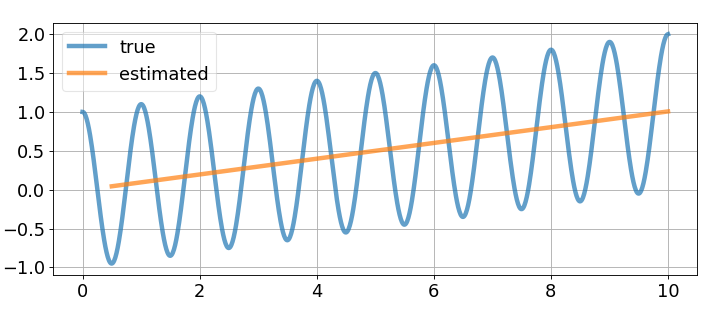

In [51]:
from numpy.lib.stride_tricks import as_strided
fig, ax = plt.subplots(1, figsize=(9, 4))
N = 1000;  L = 50
u = np.linspace(0, 10, num=N)
U = as_strided(u, [len(u)-L , L], strides=[u.strides[0], u.strides[0]])
d = np.cos(2*np.pi*u) + 0.1*u
Ruu = np.dot(U[:, :L].T, U[:, :L])
Rud = np.dot(U[:, :L].T, d[L:, np.newaxis])
h = np.linalg.solve(Ruu, Rud)[:, 0]
ax.plot(u, d, lw=4, alpha=0.7, label='true')
ax.plot(u[L:], np.dot(U, h), lw=4, alpha=0.7, label='estimated'); plt.legend();

- Para solucionar esto necesitamos un modelo que no esté limitado a relaciones lineales
$$
y_n = f_\Omega (\textbf{u}_n)
$$
- Dos maneras de lograr esto 
    - Filtros no-lineales de topología fija: Perceptrón multicapa
    - Método no-paramétrico: **Kernels**

***

## Kernels


- Los filtros basados en kernels operan en un espacio de hilbert con kernel reproductor (RKHS)
- **Espacio de Hilbert:** Espacio infinito de funciones con producto interno (producto punto)
$$
\langle f, g \rangle = \int_{-\infty}^\infty f(x) g(x) dx < \infty
$$
donde $f, g \in H$ son funciones de $\mathbb{R}^N \to \mathbb{R}$s donde $x\in \mathbb{R}^N$
- **Propiedad reproductora:** Existe un elemento de $H$ llamado $\varphi(x)$ tal que
$$
f(x) = \langle f, \varphi(x)  \rangle \quad \forall f \in H
$$
y entonces
$$
\kappa(x, y) = \langle \varphi(x), \varphi(y)  \rangle
$$
se conoce como el **kernel reproductor** de $H$ a $\kappa(x, y): \mathbb{R}^N \times \mathbb{R}^N \to \mathbb{R}$ que es una función simétrica y semidefinido positiva

Esta última igualdad se conoce como **truco del kernel**

***
Usando el truco del kernel podemos convertir un algoritmo lineal a no-lineal reeplazando un producto escalar por un kernel

***

## Kernels y transformaciones no lineales

- Un kernel induce una transformación no lineal en la entrada
- Por ejemplo consideremos el kernel polinomial de segundo grado y asumamos datos de entrada bidimensionales
$$
\begin{align}
\kappa(x, y) &= \langle x, y \rangle^2 \nonumber \\
&= (x_1 y_1)^2 + 2 x_1 y_1 x_2 y_2 + (x_2 y_2)^2 \nonumber \\
&= \Bigg \langle \begin{pmatrix} x_1^2 \\ \sqrt{2} x_1 x_2 \\ x_2^2 \end{pmatrix} \begin{pmatrix} y_1^2 \\ \sqrt{2} y_1 y_2 \\ y_2^2 \end{pmatrix} \Bigg \rangle \nonumber
\end{align}
$$
- Se induce una transformación no lineal a un espacio de tres dimensiones


<IPython.core.display.Javascript object>


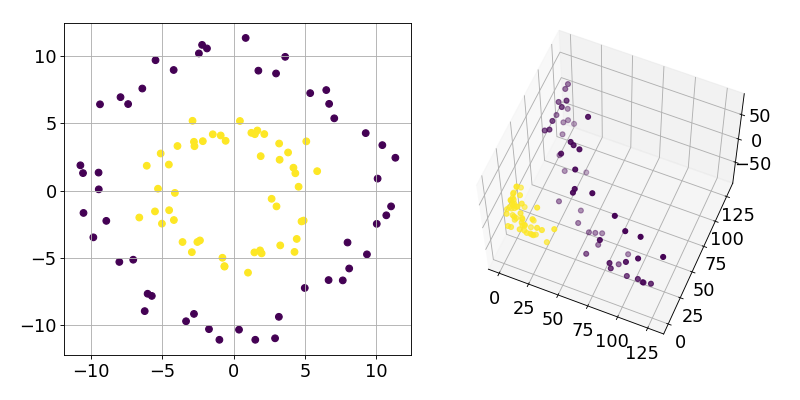

In [50]:
from mpl_toolkits import mplot3d
from sklearn.datasets import make_circles

X, Y = make_circles(n_samples=100, noise=0.08, factor=0.5); X = 10*X
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(X[:, 0], X[:, 1], c=Y)
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(X[:, 0]**2, X[:, 1]**2, np.sqrt(2)*X[:,0]*X[:,1], c=Y);

- Consideremos ahora el kernel Gaussiano o RBF para datos N-dimensionales
$$
\begin{align}
\kappa(x, y) &= e^{-\gamma \|x-y\|^2} \nonumber \\
&= e^{-\gamma \|x\|^2} e^{-\gamma \|y\|^2} e^{2\gamma \langle x, y \rangle} \nonumber \\
&= e^{-\gamma \|x\|^2} e^{-\gamma \|y\|^2} \sum_{k=0}^\infty \frac{1}{k!} (2\gamma \langle x, y \rangle)^k \nonumber \\
&= \sum_{k=0}^\infty \Bigg \langle \sqrt{2} \gamma \frac{x}{\sqrt[{2k}]{k!}} e^{-\gamma k^{-1} \|x\|^2}  , \sqrt{2} \gamma \frac{y}{\sqrt[{2k}]{k!}} e^{-\gamma k^{-1} \|y\|^2}  \Bigg \rangle^k \nonumber 
\end{align}
$$
- Se induce una transformación no lineal a un espacio infinito dimensional!

# Kernel Least Mean Square (KLMS)

***
Recordemos, en el algoritmo LMS teniamos un filtro lineal
$$
y_n = \langle \textbf{w} , \textbf{u}_n  \rangle
$$
y minimizamos el error cuadrático instantaneo (SGD)
$$
e_n^2 = (d_n - y_n)^2
$$
lo que resultaba en
$$
\begin{align}
\textbf{w}_{n+1} &= \textbf{w}_{n} + 2 \mu e_n \textbf{u}_{n}\nonumber \\
&= \textbf{w}_{n} + 2 \mu (d_n -  \textbf{w}_{n}^T \textbf{u}_{n}) \textbf{u}_{n}, \nonumber 
\end{align}
$$
***
Asumamos que
- Transformamos los datos usando $\varphi(\cdot)$, una transformacion no lineal
- Nuestro filtro es lineal en el espacio transformado
$$
y_n = \langle \Omega , \varphi(\textbf{u}_n)  \rangle
$$
- Los parámetros iniciales son nulos $\Omega_0 = 0$

Luego podemos actualizar los parámetros de nuestro filtro
$$
\begin{align}
\Omega_{n+1} &= \Omega_{n} + 2 \mu e_n \varphi(\textbf{u}_n) \nonumber \\
&= 2\mu \sum_{k=0}^n e_k \varphi(\textbf{u}_k) \nonumber
\end{align}
$$
por lo que nuestro filtro no lineal 

$$
\begin{align}
f_\Omega(\textbf{u}_{n+1}) &= \langle \Omega_{n+1} , \varphi(\textbf{u}_{n+1})  \rangle \nonumber \\
&= 2\mu \sum_{k=0}^n e_k \langle \varphi(\textbf{u}_k), \varphi(\textbf{u}_{n+1}) \rangle \nonumber \\
&= 2\mu \sum_{k=0}^n e_k \kappa(\textbf{u}_k, \textbf{u}_{n+1}) \nonumber \\
&= \sum_{k=0}^n \alpha_k \kappa(\textbf{u}_k, \textbf{u}_{n+1}) \nonumber 
\end{align}
$$

- No necesitamos conocer $\Omega$ 
- **Topología creciente:** Se necesita guardar $(\alpha_k, \textbf{u}_k)$


## Algoritmo KLMS

- Definir $\mu$ y el kernel (e.g. RBF con parámetro $\gamma$)
- Inicializar $\alpha_0 = 0$, inicializar diccionario $\mathcal{D} = \{\}$
- Para $n=1, \ldots, N$
    1. Calcular salida del filtro
    $$
    y_{n} = \sum_{k=0}^{n-1} \alpha_k \kappa(\textbf{u}_k, \textbf{u}_{n})
    $$
    1. Calcular nuevo alpha
    $$
    \alpha_{n} = 2 \mu (d_{n}- y_{n})
    $$
    1. Guardar elemento en el diccionario
    $$
    \mathcal{D} = \{\mathcal{D}, (\alpha_n, u_n)\}
    $$

## Doblamiento de frecuencia


<IPython.core.display.Javascript object>


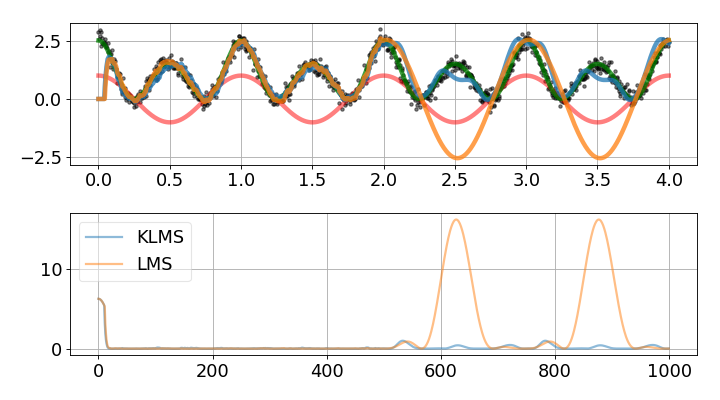

interactive(children=(SelectionSlider(continuous_update=False, description='mu', index=2, layout=Layout(height…

In [124]:
N = 1000;  
t = np.linspace(0, 4, num=N)
u = np.cos(2*np.pi*t)
d_clean = 2*u**2 + 0.5*u**3
fig, ax = plt.subplots(2, figsize=(9, 5))

def update(mu, gamma, L, rseed):
    alfa, D = list(), list()
    w = np.zeros(shape=(L+1, ))
    np.random.seed(rseed)
    d = d_clean + 0.2*np.random.randn(len(t))
    ax[0].cla(); ax[1].cla(); 
    y = np.zeros(shape=(len(u), 2))
    alfa.append(2*mu*d[L+1])
    D.append(u[:L+1])
    # KLMS
    for n in range(L+1, N):
        y[n, 0] = np.sum(np.array(alfa)*np.exp(-gamma*np.sum((u[n-L-1:n] - np.array(D))**2, axis=1)))
        if n < 500:
            alfa.append(2*mu*(d[n+1]-y[n, 0]))
            D.append(u[n-L-1:n])
    for n in range(L+1, N):
        y[n, 1] = np.dot(w, u[n-L-1:n])
        if n < 500:
            norm = np.sum(u[n-L-1:n]**2) + 1e-6
            w += 2*mu*(d[n+1] - y[n, 1])*u[n-L-1:n]/norm
    
    ax[0].plot(t, d, 'k.', alpha=0.5); ax[0].plot(t, u, 'r-', alpha=0.5, lw=4);
    ax[0].plot(t, d_clean, 'g-', alpha=0.75, lw=4);  ax[0].plot(t, y, alpha=0.75, lw=4); 
    ax[1].plot((d_clean - y[:, 0])**2, label='KLMS', alpha=0.5)
    ax[1].plot((d_clean - y[:, 1])**2, label='LMS', alpha=0.5); ax[1].legend()
    
interact(update, mu=SelectionSlider_nice(options=[0.01, 0.05, 0.1, 0.2, 0.5, 1.], value=0.1),
         gamma=SelectionSlider_nice(options=[0.001, 0.01, 0.1, 0.5, 1, 2, 5], value=0.1), 
         L=SelectionSlider_nice(options=[1, 5, 10, 20, 50], value=10),
         rseed=IntSlider_nice());

In [ ]:
KLMS para clasificación

https://github.com/EderSantana/adaptive_kernel_methods/blob/master/test_klms_classify.py

### Criterio de novedad

- Para evitar que $\mathcal{D}$ crezca demasiado se puede imponer un criterio de *sparsity*
- Por ejemplo, solo incorporar al diccionario una muestra que sea "distinta" de las anteriores
    - Si $\min_{k=1,\ldots, n} (u_{n+1} - u_{k})^2 < \delta$ entonces ignoramos la muestra nueva

- http://www.cnel.ufl.edu/news/invited_talks/principe2011_asilomar.pdf
- http://www1.ece.neu.edu/~erdogmus/publications/J043_SPM_ITLreview.pdf